In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime
import openpyxl

In [162]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [163]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [67]:
tiering = pd.read_excel('files/Device List.xlsx', sheet_name = 'Device Tiers for Reporting')
tiering['Tier'] = tiering['Tier'].str.replace('[Tier|tier|teir]','').str.replace(' ','')
tiering['Tier'].unique()

<ipython-input-67-1de8e4b6ec03>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tiering['Tier'] = tiering['Tier'].str.replace('[Tier|tier|teir]','').str.replace(' ','')


array(['3', '2', '1'], dtype=object)

In [5]:
start_date = '2021-02-25'
end_date = '2021-03-13'

In [6]:
perf_query = """
with mod as 
(
    select
        p.uid || '_' || t.transactionid as igniteID
        , max(dtr.model) as model
    from rawdata.dt_transactions t
    join rawdata.dt_transactions_events te 
        on t.transactionid = te.transactionid
    join rawdata.dt_events e
        on e.eventid = te.eventid 
        and e.rs_carrier_id = te.rs_carrier_id
    join rawdata.dt_process p
        on t.processid = p.processid 
        and p.rs_carrier_id = t.rs_carrier_id 
        and p.processtypeid = 1
        and left(p.uid,1) = '0'
    join rawdata.dt_device_report dtr
        on dtr.processid = t.processid
        and dtr.rs_carrier_id = p.rs_carrier_id 
    where 
        date(te.eventdate) >= date('{start_date}') - 30 
        and date(te.eventdate) <= '{end_date}'
    group by 1
) 
select 
    site_name
    , site_id
    , carrier_name
    , model
    , sum(preload)*16 as preload 
    , sum(install)*16 as install 
    , sum(d7_events)*16 as d7_events
    , sum(d7_rev)*16 as d7_rev 
    , sum(d30_events)*16 as d30_events
    , sum(d30_rev)*16 as d30_rev 
    , sum(spend)*16 as spend 
from
(
    select
        s.site_id
        , s.site_name
        , pi.partner_name as carrier_name
        , mod.model
        , count(distinct ctp.referrer) as preload
        , 0 as install
        , 0 as d7_events
        , 0 as d7_rev
        , 0 as d30_events
        , 0 as d30_rev
        , sum(case when billing_type = 'CPP' then ctp.gross_payout else 0 end) as spend 
    from rawdata.campaign_tracking_active_preload ctp
    join rawdata.campaign c 
        on ctp.campaign_id = c.campaign_id 
        and c.bid_price_per_download > 0
    join rawdata.site s 
        on ctp.site_id = s.site_id
    join rawdata.partner_information pi
        on pi.partner_id = s.partner_id 
    left join mod 
        on ctp.reqid = mod.igniteID
    where 
        date(ctp.tracking_time) >= '{start_date}'
        and date(ctp.tracking_time) <= '{end_date}'
        and left(ctp.reqid,1) = '0'
    group by 1,2,3,4

    union all

    select
        s.site_id
        , s.site_name
        , pi.partner_name as carrier_name
        , mod.model
        , 0 as preload
        , count(distinct cti.referrer) as install
        , 0 as d7_events
        , 0 as d7_rev
        , 0 as d30_events
        , 0 as d30_rev
        , sum(case when billing_type = 'CPI' then cti.gross_payout else 0 end) as spend 
    from rawdata.campaign_tracking_active_install cti
    join rawdata.campaign c 
        on cti.campaign_id = c.campaign_id 
        and c.bid_price_per_download > 0
    join rawdata.site s 
        on cti.site_id = s.site_id
    join rawdata.partner_information pi
        on pi.partner_id = s.partner_id 
    left join mod 
        on cti.reqid = mod.igniteID
    where 
        date(cti.tracking_time) >= '{start_date}'
        and date(cti.tracking_time) <= '{end_date}'
        and left(cti.reqid,1) = '0'
    group by 1,2,3,4

    union all 

    select
        cti.site_id
        , cti.site_name
        , cti.carrier_name
        , cti.model
        , 0 as preload
        , 0 as install
        , count(distinct case when datediff(day, cti.tracking_time::timestamp, pi.event_date::timestamp) <= 7 then pi.referrer else NULL end) as d7_events
        , sum(case when event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$' and datediff(day, cti.tracking_time::timestamp, pi.event_date::timestamp) <= 7 then event_var else 0::varchar END) as d7_rev
        , count(distinct pi.referrer) as d30_events
        , sum(case when event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$' then event_var else 0::varchar END) as d30_rev
        , 0 as spend 
    from rawdata.pi_data pi 
    join 
    (
        select 
            referrer 
            , tracking_time
            , s.site_id
            , s.site_name
            , pi.partner_name as carrier_name
            , mod.model
        from rawdata.campaign_tracking_active_install cti 
        join rawdata.campaign c 
            on cti.campaign_id = c.campaign_id 
            and c.bid_price_per_download > 0
        join rawdata.site s 
            on cti.site_id = s.site_id
        join rawdata.partner_information pi
            on pi.partner_id = s.partner_id 
        left join mod 
            on cti.reqid = mod.igniteID
        where 
            date(cti.tracking_time) >= '{start_date}'
            and date(cti.tracking_time) <= '{end_date}'
            and left(cti.reqid,1) = '0'
        group by 1,2,3,4,5,6
    ) cti
        on cti.referrer = pi.referrer
        and datediff(day, cti.tracking_time::timestamp, pi.event_date::timestamp) <= 30
        and pi.event_date >= cti.tracking_time      
    where 
        date(event_date) >= '{start_date}'
        and date(event_date) <= date('{end_date}') + interval '30 day'
        and (lower(pi.event) like '%purchase%'
            or lower(pi.event) like '%order%'
            or lower(pi.event) like '%revenue%'
            or (event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$'
            and event_var != 0)) 
        and lower(pi.event) not like '%reorder%'
        and lower(pi.event) not like '%refund%'
        and lower(pi.event) not like '%cancel%'
    group by 1,2,3,4
) t
group by 1,2,3,4
"""

In [7]:
cur_atlas.execute(perf_query.format(start_date = start_date, end_date = end_date))
df_perf = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
df_perf['spend'] = df_perf['spend'].astype('float')
df_perf['d7_rev'] = df_perf['d7_rev'].astype('float')
df_perf['d30_rev'] = df_perf['d30_rev'].astype('float')

In [73]:
by_site_merged = pd.merge(df_perf, tiering, left_on = 'site_id', right_on = 'Site ID', how = 'left')
by_site_merged.loc[~by_site_merged.Carrier.isna()].groupby(['carrier_name','Carrier']).count()

site_name  site_id  model  preload  install  \
carrier_name    Carrier                                                    
DT AT&T         AT&T               499      499    258      499      499   
DT Cricket      Cricket            257      257    137      257      257   
DT Tracfone     Tracfone           119      119     78      119      119   
DT US Cellular  US Cellular        213      213    103      213      213   
DT Verizon      Verizon            234      234    124      234      234   

                             d7_events  d7_rev  d30_events  d30_rev  spend  \
carrier_name    Carrier                                                      
DT AT&T         AT&T               499     499         499      499    499   
DT Cricket      Cricket            257     257         257      257    257   
DT Tracfone     Tracfone           119     119         119      119    119   
DT US Cellular  US Cellular        213     213         213      213    213   
DT Verizon      Verizon            234     234         234      234    234   

                             Site ID  Flow  Tier  
carrier_name    Carrier                           
DT AT&T         AT&T             499   499   499  
DT Cricket      Cricket          257   257   257  
DT Tracfone     Tracfone         119   119   119  
DT US Cellular  US Cellular      213   213   213  
DT Verizon      Verizon          234   234   234

In [188]:
by_tier = by_site_merged.loc[~by_site_merged.Carrier.isna()].pivot_table(values = ['spend','d7_events','d7_rev','d30_events','d30_rev'], index = ['model','Tier'], aggfunc = np.sum)
by_tier['d7_roas'] = by_tier['d7_rev']/by_tier['spend']
by_tier['d30_roas'] = by_tier['d30_rev']/by_tier['spend']
by_tier['d7_cpa'] = by_tier['spend']/by_tier['d7_events']
by_tier['d30_cpa'] = by_tier['spend']/by_tier['d30_events']
by_tier.reset_index(inplace = True)
by_tier
fig, ax = plt.subplots(3,1,figsize = (10,10), sharex = True, sharey = True)
ax[0].scatter('spend','d30_cpa', data = by_tier[by_tier.Tier == '1'])
ax[1].scatter('spend','d30_cpa', data = by_tier[by_tier.Tier == '2'])
ax[2].scatter('spend','d30_cpa', data = by_tier[by_tier.Tier == '3'])
ax[0].set_xlabel('Spend')


Text(0.5, 0, 'Test')

In [164]:
launches_query = """
select
    ef.site_id
    , sd.site_name
    , sd.partner_name
    , date(event_timestamp) as date
    , sum(preload_count) preloads
from venus.event_fact ef 
join venus.site_dimension sd 
    on ef.site_id = sd.site_id
where
    date(event_timestamp) >= date('{start_date}') - 90 
    and date(event_timestamp) <= date('{end_date}')
group by 1,2,3,4
"""

In [165]:
cur_olympus.execute(launches_query.format(start_date = start_date, end_date = end_date))
df_launches = pd.DataFrame(cur_olympus.fetchall(), columns = [c[0] for c in cur_olympus.description])

<AxesSubplot:xlabel='date'>

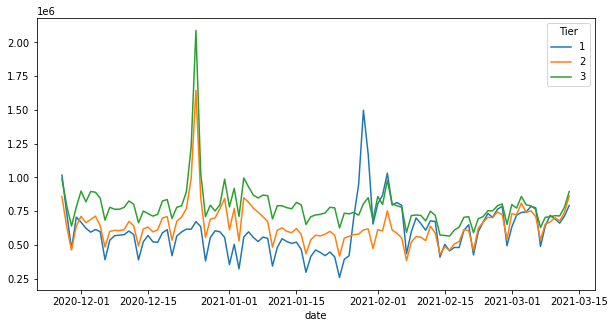

In [166]:
df_launches_merged = pd.merge(df_launches, tiering, left_on = 'site_id', right_on = 'Site ID', how = 'left')
df_launches_merged.pivot_table(values = 'preloads', index = 'date', columns = 'Tier', aggfunc = np.sum).plot(figsize = (10,5))

<AxesSubplot:xlabel='date'>

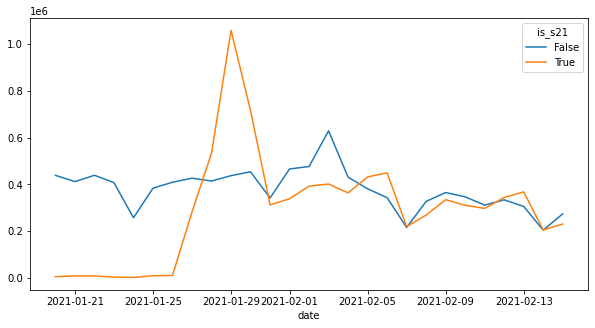

In [181]:
df_launches_merged['is_s21'] = df_launches_merged.site_name.str.contains('S21')
df_launches_merged[(df_launches_merged.Tier == '1') & (df_launches_merged.date >= datetime.date(2021,1,20)) & (df_launches_merged.date <= datetime.date(2021,2,15))].pivot_table(values = 'preloads', index = 'date', columns = 'is_s21', aggfunc =np.sum).plot(figsize = (10,5))

In [185]:
df_launches_merged.loc[df_launches_merged.Tier == '1', 'site_name'].unique()

array(['DT - ATT - US - Ignite - Samsung - Galaxy S10+ - SM-G975U - Silent',
       'DT - ATT - US - Ignite - Samsung - Galaxy Note 10+ 5G - SM-N976U - Silent',
       'DT - ATT - US - Ignite - LG - V60 ThinQ 5G - LM-V600 - Silent',
       'DT - ATT - US - Ignite - LG - Velvet - LM-G900 - AppSelect',
       'DT - ATT - US - Ignite - Samsung - Galaxy Tab S7 5G - SM-T878U - AppSelect',
       'DT - Verizon - US - Ignite - LG G7 - LMG710VM',
       'DT - ATT - US - Ignite - Samsung - Galaxy Z Flip 5G - SM-F707U - Silent',
       'DT - ATT - US - Ignite - Motorola - One 5G - XT2075-2 - Silent',
       'DT - ATT - US - Ignite - Samsung - Galaxy Note 10 - SM-N970U - AppSelect',
       'DT - Cricket - US - Ignite - Samsung - Galaxy S10 - SM-G973U - Games',
       'DT - ATT\xa0- US - Ignite - Samsung - Galaxy Note 20 5G - SM-N981U - Games',
       'DT - ATT - US - Ignite - Samsung - Galaxy Note 9 - SM-N960U - Silent',
       'DT - Verizon - US - Ignite - Samsung - Note 9 - SM-N960U',
       'D